In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.ndimage.interpolation import shift
import os
import seaborn as sns
import json

from pdftabextract.common import read_xml, parse_pages
from pdftabextract.clustering import zip_clusters_and_values
from pdftabextract.textboxes import border_positions_from_texts, split_texts_by_positions, join_texts
from pdftabextract.common import all_a_in_b, DIRECTION_VERTICAL
from pdftabextract.clustering import find_clusters_1d_break_dist
from pdftabextract.clustering import calc_cluster_centers_1d
from pdftabextract.extract import make_grid_from_positions
from pdftabextract.extract import fit_texts_into_grid, datatable_to_dataframe

from tabula import read_pdf
import pandas as pd

%matplotlib inline

In [2]:
from tables_detector.tables_detector import TableDetector

In [3]:

dat_path = "../../../dat/DATASETS/NL 14614829 - Claim File- image 1_Part 1/Output"
#dat_path = "../../../dat"

In [4]:
pdf_file_name = 'Accident-Handwritten_V3.pdf'
#pdf_file_name = 'Deidentified medical record.pdf'
#pdf_file_name = 'EgyptJHaematol_2012_37_4_207_134966_5.pdf'

base_file_name = os.path.splitext(pdf_file_name)[0]
page_num = 1
# Convert pdf to tiff
cmd = 'convert -density 300 ' + pdf_file_name + '[' + str(page_num-1) + ']' + ' ' + base_file_name+'.tiff'
#cmd = 'convert -density 150 ' + pdf_file_name + ' ' + base_file_name+'.tiff'
#os.system(cmd)

# Convert tiff to pdf sandwitch
cmd = 'tesseract' + ' ' + base_file_name+'.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
#cmd = 'tesseract' + ' ' + 'Page 3.tiff' + ' ' + base_file_name+'_pdf_sand' + ' pdf'
#os.system(cmd)

# Convert pdf sandwitch to xml
xml_file = base_file_name+'.xml'
cmd = 'pdftohtml -c -hidden -xml' + ' ' + base_file_name+'_pdf_sand.pdf' + ' ' + xml_file
#os.system(cmd)

In [5]:
#!python3 -m http.server 8080 --bind 127.0.0.1

 http://127.0.0.1:8080/pdf2xml-viewer.html.

In [6]:
#xml_file = '0e521b72-651c-4a00-b4b8-2803d3b91f79_1.xml'
file_name = base_file_name+'.tiff'
#file_name = '0e521b72-651c-4a00-b4b8-2803d3b91f79_1.tiff'

#file_name = 'Page 3.jpg' # OK
#file_name = 'Page 5.jpg' # OK
#file_name = 'Page 7.jpg' # OK
#file_name = 'Page 8.jpg' # NOK
#file_name = 'Page 3.tiff' # NOK
#file_name = 'Page 3_mod.tiff' # NOK
#file_name = 'Page 3_mod_no_table.tiff' # NOK
#img_orig = cv2.imread(os.path.join(dat_path, file_name), 0)
img_orig = cv2.imread(file_name, 0)
img = (255 - img_orig.copy())/255
img = img[:, :-100]

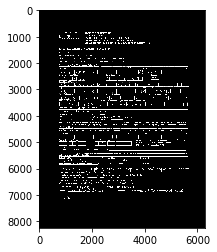

In [7]:
plt.imshow(img,cmap='gray')

In [8]:
img.shape

(8250, 6275)

In [9]:
'''
#img_new = cv2.resize(img, (img.shape[0], img.shape[1] + 100))
img_new = np.zeros((img.shape[0], img.shape[1] + 100))
img_new[:, 100:] = img
#img_new = np.concatenate(np.zeros((img.shape[0], 100)), img)
plt.imshow(img_new,cmap='gray')
img = img_new.copy()
'''

"\n#img_new = cv2.resize(img, (img.shape[0], img.shape[1] + 100))\nimg_new = np.zeros((img.shape[0], img.shape[1] + 100))\nimg_new[:, 100:] = img\n#img_new = np.concatenate(np.zeros((img.shape[0], 100)), img)\nplt.imshow(img_new,cmap='gray')\nimg = img_new.copy()\n"

> Grid with 3 rows, 3 columns
list index out of range
Empty table

> Grid with 17 rows, 4 columns
> Grid with 3 rows, 2 columns
> Grid with 8 rows, 5 columns
> Grid with 3 rows, 3 columns
lefttop[0] must be smaller than rightbottom[0] to form a rectangle
Empty table

lefttop[0] must be smaller than rightbottom[0] to form a rectangle
Empty table

> Grid with 1 rows, 6 columns


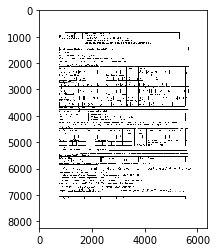

'{"data": [{"col1": {"0": "O O", "1": "", "2": "Mfl\\u00a9ffl"}, "col2": {"0": "O", "1": "*", "2": ""}, "col3": {"0": "ACCIDENT CLAIM FORM", "1": "The Benefits Center", "2": "Roe. Bil \\u00a303158, golumbia, SC 29202-3158"}}, {"col1": {"0": "Last Name", "1": "", "2": "C|G|uU|I|R]|E", "3": "Date of Birth (mm/dd/yy)                 Sccial Security Number", "4": "", "5": "[2] [1T+] 319 711-14]", "6": "ome Address", "7": "", "8": "|C] |\\u00a76]A|x|o |N |A|V|E]. 8) AIV", "9": "", "10": "City", "11": "|A |V |F K]T |o w) N", "12": "Home Telephone Number H                 Cellular Telephone Number", "13": "21812 P] |4 11s 4] 4]\\u00a2", "14": "Accident Policy Number                   Preferred e-mail address (for confirmation purposes only)", "15": "", "16": "4             (|   ol   2|   t     In   le   |s   (h   la   Iw"}, "col2": {"0": "Suffix", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "|F [R] T|", "9": "", "10": "", "11": "", "12": "", "13": "[6", "14": "", "15":

In [10]:
verbose = False
# 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.25)
#tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=50, min_col_width=100, ratio_clip_max=0.25)
tables = tables_detector.detect_tables(img)

tables_detector.fit_text_to_tables(xml_file)
tables_detector.visualize_tables(img_orig, file_name)
#tables_detector.save_json(base_file_name)
list_of_json_tables = tables_detector.get_tables_in_json()
json.dumps({"data": list_of_json_tables})

In [11]:
list_of_json_tables

[{'col1': {'0': 'O O', '1': '', '2': 'Mfl©ffl'},
  'col2': {'0': 'O', '1': '*', '2': ''},
  'col3': {'0': 'ACCIDENT CLAIM FORM',
   '1': 'The Benefits Center',
   '2': 'Roe. Bil £03158, golumbia, SC 29202-3158'}},
 {'col1': {'0': 'Last Name',
   '1': '',
   '2': 'C|G|uU|I|R]|E',
   '3': 'Date of Birth (mm/dd/yy)                 Sccial Security Number',
   '4': '',
   '5': '[2] [1T+] 319 711-14]',
   '6': 'ome Address',
   '7': '',
   '8': '|C] |§6]A|x|o |N |A|V|E]. 8) AIV',
   '9': '',
   '10': 'City',
   '11': '|A |V |F K]T |o w) N',
   '12': 'Home Telephone Number H                 Cellular Telephone Number',
   '13': '21812 P] |4 11s 4] 4]¢',
   '14': 'Accident Policy Number                   Preferred e-mail address (for confirmation purposes only)',
   '15': '',
   '16': '4             (|   ol   2|   t     In   le   |s   (h   la   Iw'},
  'col2': {'0': 'Suffix',
   '1': '',
   '2': '',
   '3': '',
   '4': '',
   '5': '',
   '6': '',
   '7': '',
   '8': '|F [R] T|',
   '9': '',
   

In [12]:
tables_detector.tables

[{'table_start': 850,
  'col_positions': array([ 974, 1349, 1649, 5301]),
  'table_end': 1100},
 {'table_start': 2150,
  'col_positions': array([ 749, 3299, 3749, 5474, 5526]),
  'table_end': 3650},
 {'table_start': 3900,
  'col_positions': array([ 749, 1874, 5526]),
  'table_end': 4200},
 {'table_start': 4500,
  'col_positions': array([ 749, 3149, 3599, 4049, 4799, 5526]),
  'table_end': 5150},
 {'table_start': 5550,
  'col_positions': array([ 749, 2324, 3749, 5526]),
  'table_end': 5750},
 {'table_start': 7050,
  'col_positions': array([ 749, 1724, 2324, 2924, 4724, 5324, 5526]),
  'table_end': 7150}]

In [13]:
coordinates = []
for table in tables_detector.tables:
    #json.loads(table.to_json().encode('utf-8').decode('utf-8'))
    coordinates.append({'x1': int(table['col_positions'][0]), 'y1':int(table['table_start']) , 'x2':int(table['col_positions'][-1]),'y2': int(table['table_end'])})


In [14]:
coordinates

[{'x1': 974, 'y1': 850, 'x2': 5301, 'y2': 1100},
 {'x1': 749, 'y1': 2150, 'x2': 5526, 'y2': 3650},
 {'x1': 749, 'y1': 3900, 'x2': 5526, 'y2': 4200},
 {'x1': 749, 'y1': 4500, 'x2': 5526, 'y2': 5150},
 {'x1': 749, 'y1': 5550, 'x2': 5526, 'y2': 5750},
 {'x1': 749, 'y1': 7050, 'x2': 5526, 'y2': 7150}]

In [15]:
json.dumps({"data": list_of_json_tables, "coordinates": coordinates})

'{"data": [{"col1": {"0": "O O", "1": "", "2": "Mfl\\u00a9ffl"}, "col2": {"0": "O", "1": "*", "2": ""}, "col3": {"0": "ACCIDENT CLAIM FORM", "1": "The Benefits Center", "2": "Roe. Bil \\u00a303158, golumbia, SC 29202-3158"}}, {"col1": {"0": "Last Name", "1": "", "2": "C|G|uU|I|R]|E", "3": "Date of Birth (mm/dd/yy)                 Sccial Security Number", "4": "", "5": "[2] [1T+] 319 711-14]", "6": "ome Address", "7": "", "8": "|C] |\\u00a76]A|x|o |N |A|V|E]. 8) AIV", "9": "", "10": "City", "11": "|A |V |F K]T |o w) N", "12": "Home Telephone Number H                 Cellular Telephone Number", "13": "21812 P] |4 11s 4] 4]\\u00a2", "14": "Accident Policy Number                   Preferred e-mail address (for confirmation purposes only)", "15": "", "16": "4             (|   ol   2|   t     In   le   |s   (h   la   Iw"}, "col2": {"0": "Suffix", "1": "", "2": "", "3": "", "4": "", "5": "", "6": "", "7": "", "8": "|F [R] T|", "9": "", "10": "", "11": "", "12": "", "13": "[6", "14": "", "15":

In [19]:

df_tabula = read_pdf(pdf_file_name)# If tables with lines, better use tabula 

try:
    df_tabula.to_json(base_file_name+'.json')
    list_of_json_tables = [json.loads(df_tabula.to_json())]
    
except:
    verbose = False
    # 3508x2379 ~ 90linesx25words ~ pixels/word = 96, pixels/line=40--> strip_height > 40 (*2 for header usually > 2 lines) (100) w_max_pool < 96 (50)
    tables_detector = TableDetector(verbose, strip_height=50, w_max_pool=75, min_col_width=250, ratio_clip_max=0.25)
    tables = tables_detector.detect_tables(img)
    tables_detector.visualize_tables(img_orig, file_name)
    tables_detector.fit_text_to_tables(xml_file)
    #tables_detector.save_json(base_file_name)
    list_of_json_tables = tables_detector.get_tables_in_json()
    
json.dumps({"data": list_of_json_tables})

Error: 


CalledProcessError: Command '['java', '-Dfile.encoding=UTF8', '-jar', '/home/ahmad/Work/OCR/cod/TableIdentification/table_identification/tabula/tabula-1.0.2-jar-with-dependencies.jar', '--pages', '1', '--guess', '0e521b72-651c-4a00-b4b8-2803d3b.pdf']' returned non-zero exit status 1.

In [20]:
df_tabula

,Dates of Diagnosis,;,Unnamed: 2,Diagnosis Description,Unnamed: 4,lrocsdure!,”Procedure Description
0,Service (including Code (ICD);,NaN,NaN,NaN,NaN,Code,NaN
1,Confinement),NaN,NaN,NaN,NaN,NaN,NaN
2,IZ |S90.190A,NaN,NaN,Corctusion of kt,toe,NaN,NaN
3,|,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
with open(base_file_name+'.json', 'w') as outfile:  
    json.dump({"data": list_of_json_tables}, outfile)